In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [2]:
train_df = pd.read_csv("tweets_21.csv")
test_df = pd.read_csv("tweets_labeled.csv")

In [3]:
train_df.head()

,tweet_id,tweet,date
0,1344798002490314752,Kardesim (12) sevdigi cocuga 00:00 da ilan-i a...,2021-01-01 03:10:03
1,1344799527673470977,Bu yılbaşı da saat tam 00:00'da swni seviyorum...,2021-01-01 03:16:07
2,1344799907719348226,tam 00.00da naptınız ben her yıl tam bu vakit ...,2021-01-01 03:17:37
3,1344800782802165762,00:00'da havai fişek gösterisi yapıldı tam dib...,2021-01-01 03:21:06
4,1344805589990453249,31 aralık saat 00.00 da yeni yılımızı kutlayan...,2021-01-01 03:40:12


In [4]:
test_df.head()

,tweet_id,tweet,date,label
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-24 21:41:37+00:00,1
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-15 21:00:18+00:00,1
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-13 21:21:36+00:00,1
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 15:03:47+00:00,1
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 20:22:32+00:00,1


In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13272 entries, 0 to 13271
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  13272 non-null  int64 
 1   tweet     13272 non-null  object
 2   date      13272 non-null  object
dtypes: int64(1), object(2)
memory usage: 311.2+ KB


In [6]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12960 entries, 0 to 12959
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   tweet_id  12960 non-null  int64 
 1   tweet     12959 non-null  object
 2   date      12960 non-null  object
 3   label     12960 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 405.1+ KB


## Data Cleaning and Future Extraction

#### Cleaning
1. localize "date" column for EDA
2. change all tweets to lower case
3. emoticon classification
4. replace special characters and number with space
5. remove tweets with one word

##### 1. localize "date" column for EDA

In [7]:
test_df.isna().sum()

tweet_id    0
tweet       1
date        0
label       0
dtype: int64

In [8]:
train_df.isna().sum()

tweet_id    0
tweet       0
date        0
dtype: int64

In [9]:
test_df["date"] = pd.to_datetime(test_df["date"])
test_df['date'] = test_df['date'].dt.tz_localize(None)
train_df["date"] = pd.to_datetime(train_df["date"])
train_df['date'] = test_df['date'].dt.tz_localize(None)

In [10]:
test_df["month"] = test_df["date"].dt.month_name()
train_df["month"] = train_df["date"].dt.month_name()

In [11]:
def replace_month_names(df, column_name):
    month_translation = {
        'December': 'Aralık',
        'January': 'Ocak',
        'February': 'Şubat',
        'March': 'Mart',
        'April': 'Nisan',
        'May': 'Mayıs',
        'June': 'Haziran',
        'July': 'Temmuz',
        'August': 'Ağustos',
        'September': 'Eylül',
        'October': 'Ekim',
        'November': 'Kasım'
    }
    df[column_name] = df[column_name].replace(month_translation)
    return df

test_df = replace_month_names(test_df, 'month')
train_df = replace_month_names(train_df, 'month')

In [12]:
seasons = {'Ocak': 'Kış',
           'Şubat': 'Kış',
           'Mart': 'İlkbahar',
           'Nisan': 'İlkbahar',
           'Mayıs': 'İlkbahar',
           'Haziran': 'Yaz',
           'Temmuz': 'Yaz',
           'Ağustos': 'Yaz',
           'Eylül': 'Sonbahar',
           'Ekim': 'Sonbahar',
           'Kasım': 'Sonbahar',
           'Aralık': 'Kış'}
test_df['seasons'] = test_df['month'].map(seasons)
train_df['seasons'] = train_df['month'].map(seasons)

In [13]:
test_df = test_df.dropna()
train_df = train_df.dropna()

In [14]:
test_df["days"] = [date.strftime('%A') for date in test_df["date"]]
train_df["days"] = [date.strftime('%A') for date in train_df["date"]]

In [15]:
def replace_day_names(df,column_name):
    day_translation = {"Monday" : "Pazartesi",
                                 "Tuesday" : "Salı",
                                 "Wednesday" : "Çarşamba",
                                 "Thursday": "Perşembe",
                                 "Friday" : "Cuma",
                                 "Saturday" : "Cumartesi",
                                 "Sunday": "Pazar"}
    df[column_name] = df[column_name].replace(day_translation)
    return df

test_df = replace_day_names(test_df,"days")
train_df = replace_day_names(train_df,"days")

In [16]:
test_df['hour'] = test_df['date'].dt.hour
test_df['4hour_interval'] = (test_df['hour'] // 2) * 2
interval = {0: '0-2',
            2: '2-4',
            4: '4-6',
            6: '6-8',
            8: '8-10',
            10: '10-12',
            12: '12-14',
            14: '14-16',
            16: '16-18',
            18: '18-20',
            20: '20-22',
            22: '22-24'
            }

train_df['hour'] = train_df['date'].dt.hour
train_df['4hour_interval'] = (train_df['hour'] // 2) * 2
interval = {0: '0-2',
            2: '2-4',
            4: '4-6',
            6: '6-8',
            8: '8-10',
            10: '10-12',
            12: '12-14',
            14: '14-16',
            16: '16-18',
            18: '18-20',
            20: '20-22',
            22: '22-24'
            }

In [17]:
def replace_hour_interval(df,column_name):
    hour_tranlation = { "0-2": "22-02",
                        "22-24": "22-02",
                        "2-4": "02-06",
                        "4-6": "02-06",
                        "6-8": "06-10",
                        "8-10": "06-10",
                        "10-12": "10-14",
                        "12-14": "10-14",
                        "14-16": "14-18",
                        "16-18": "14-18",
                        "18-20": "18-22",
                        "20-22": "18-22"}
    df[column_name] = df[column_name].replace(hour_tranlation)
    return df

test_df = replace_hour_interval(test_df,"4hour_interval")
train_df = replace_hour_interval(train_df,"4hour_interval")

In [18]:
test_df.drop(["4hour_interval", "hour"], axis=1, inplace=True)
train_df.drop(["4hour_interval", "hour"], axis=1, inplace=True)

In [19]:
test_df.head()

,tweet_id,tweet,date,label,month,seasons,days
0,1606767075984375808,Berk Ali (kedim) seni çok özledim. Ölmek için ...,2022-12-24 21:41:37,1,Aralık,Kış,Cumartesi
1,1537178207677448193,"Yani, öylesine ciddiye alacaksın ki yaşamayı, ...",2022-06-15 21:00:18,1,Haziran,Yaz,Çarşamba
2,1536458790802972673,saçlarının gölgesinde\nölmek ne güzeldi,2022-06-13 21:21:36,1,Haziran,Yaz,Pazartesi
3,1495413883166760960,"Öyle güzel baktın ki, gözlerime\nsevmek değil ...",2022-02-20 15:03:47,1,Şubat,Kış,Pazar
4,1490420667614904334,sevmek biri için ölmek değil her şeye rağmen y...,2022-02-06 20:22:32,1,Şubat,Kış,Pazar


In [20]:
train_df.head()

,tweet_id,tweet,date,month,seasons,days
0,1344798002490314752,Kardesim (12) sevdigi cocuga 00:00 da ilan-i a...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi
1,1344799527673470977,Bu yılbaşı da saat tam 00:00'da swni seviyorum...,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba
2,1344799907719348226,tam 00.00da naptınız ben her yıl tam bu vakit ...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi
3,1344800782802165762,00:00'da havai fişek gösterisi yapıldı tam dib...,2022-02-20 15:03:47,Şubat,Kış,Pazar
4,1344805589990453249,31 aralık saat 00.00 da yeni yılımızı kutlayan...,2022-02-06 20:22:32,Şubat,Kış,Pazar


In [21]:
combined_df = pd.concat([train_df,test_df,], ignore_index = True)
combined_df.head()

,tweet_id,tweet,date,month,seasons,days,label
0,1344798002490314752,Kardesim (12) sevdigi cocuga 00:00 da ilan-i a...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi,NaN
1,1344799527673470977,Bu yılbaşı da saat tam 00:00'da swni seviyorum...,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba,NaN
2,1344799907719348226,tam 00.00da naptınız ben her yıl tam bu vakit ...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi,NaN
3,1344800782802165762,00:00'da havai fişek gösterisi yapıldı tam dib...,2022-02-20 15:03:47,Şubat,Kış,Pazar,NaN
4,1344805589990453249,31 aralık saat 00.00 da yeni yılımızı kutlayan...,2022-02-06 20:22:32,Şubat,Kış,Pazar,NaN


In [22]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25919 entries, 0 to 25918
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   tweet_id  25919 non-null  int64         
 1   tweet     25919 non-null  object        
 2   date      25919 non-null  datetime64[ns]
 3   month     25919 non-null  object        
 4   seasons   25919 non-null  object        
 5   days      25919 non-null  object        
 6   label     12959 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.4+ MB


##### 2. change all tweets to lower case

In [23]:
combined_df["tweet"] = combined_df["tweet"].astype(str)
train_df["tweet"] = train_df["tweet"].astype(str)
test_df["tweet"] = test_df["tweet"].astype(str)

In [24]:
combined_df["tweet"] = combined_df["tweet"].apply(lambda str1: str1.lower())
train_df["tweet"] = train_df["tweet"].apply(lambda str2: str2.lower())
test_df["tweet"] = test_df["tweet"].apply(lambda str3: str3.lower())

##### 3. emoticon classification

In [25]:
emoticon_dict = {
":)": "happy",
":‑)": "happy",
":-]": "happy",
":-3": "happy",
":->": "happy",
"8-)": "happy",
":-}": "happy",
":o)": "happy",
":c)": "happy",
":^)": "happy",
"=]": "happy",
"=)": "happy",
"<3": "happy",
":-(": "sad",
":(": "sad",
":c": "sad",
":<": "sad",
":[": "sad",
">:[": "sad",
":{": "sad",
">:(": "sad",
":-c": "sad",
":-< ": "sad",
":-[": "sad",
":-||": "sad"
}

In [26]:
def classification(text, dictionary):
    for word in text.split():
        if word.lower() in dictionary:
            if word.lower() in text.split():
                text = text.replace(word, dictionary[word.lower()])
    return text

In [27]:
combined_df["tweet"] = combined_df["tweet"].apply(lambda x: classification(x,emoticon_dict))
train_df["tweet"] = train_df["tweet"].apply(lambda x: classification(x,emoticon_dict))
test_df["tweet"] = test_df["tweet"].apply(lambda x: classification(x,emoticon_dict))

##### 4. replace special characters and number with space

In [28]:
combined_df["tweet"] = combined_df["tweet"].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
train_df["tweet"] = train_df["tweet"].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))
test_df["tweet"] = test_df["tweet"].apply(lambda x: re.sub(r'[^a-zA-Z0-9]',' ',x))

##### 5. remove tweets with one word

In [29]:
combined_df["tweet"] = combined_df["tweet"].apply(lambda x: "".join([w for w in x.split() if len(w)>1]))
train_df["tweet"] = train_df["tweet"].apply(lambda x: "".join([w for w in x.split() if len(w)>1]))
test_df["tweet"] = test_df["tweet"].apply(lambda x: "".join([w for w in x.split() if len(w)>1]))

In [30]:
combined_df.head()

,tweet_id,tweet,date,month,seasons,days,label
0,1344798002490314752,kardesim12sevdigicocuga0000dailanasketmiscocuk...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi,NaN
1,1344799527673470977,bulbadasaattam0000daswniseviyorummesajgelmedi,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba,NaN
2,1344799907719348226,tam0000danaptbenhertambuvakitdinlediimarkbalko...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi,NaN
3,1344800782802165762,0000dahavaifieksterisiyapldtamdibimizdeancakka...,2022-02-20 15:03:47,Şubat,Kış,Pazar,NaN
4,1344805589990453249,31aralsaat0000dayenikutlayanbirisiyineolmadbul...,2022-02-06 20:22:32,Şubat,Kış,Pazar,NaN


In [31]:
train_df.head()

,tweet_id,tweet,date,month,seasons,days
0,1344798002490314752,kardesim12sevdigicocuga0000dailanasketmiscocuk...,2022-12-24 21:41:37,Aralık,Kış,Cumartesi
1,1344799527673470977,bulbadasaattam0000daswniseviyorummesajgelmedi,2022-06-15 21:00:18,Haziran,Yaz,Çarşamba
2,1344799907719348226,tam0000danaptbenhertambuvakitdinlediimarkbalko...,2022-06-13 21:21:36,Haziran,Yaz,Pazartesi
3,1344800782802165762,0000dahavaifieksterisiyapldtamdibimizdeancakka...,2022-02-20 15:03:47,Şubat,Kış,Pazar
4,1344805589990453249,31aralsaat0000dayenikutlayanbirisiyineolmadbul...,2022-02-06 20:22:32,Şubat,Kış,Pazar


In [32]:
test_df.head()

,tweet_id,tweet,date,label,month,seasons,days
0,1606767075984375808,berkalikedimseniokzledimlmekindahaktseniseviyo...,2022-12-24 21:41:37,1,Aralık,Kış,Cumartesi
1,1537178207677448193,yaniylesineciddiyealacakskiyaamayyetmiindebile...,2022-06-15 21:00:18,1,Haziran,Yaz,Çarşamba
2,1536458790802972673,salarlgesindelmeknezeldi,2022-06-13 21:21:36,1,Haziran,Yaz,Pazartesi
3,1495413883166760960,ylezelbaktkizlerimesevmekdeillmekgeldiimden,2022-02-20 15:03:47,1,Şubat,Kış,Pazar
4,1490420667614904334,sevmekbiriinlmekdeilhereyeramenyaayabilmekmi,2022-02-06 20:22:32,1,Şubat,Kış,Pazar


Now we can also say that data is cleaned. From now on we will be focusing on EDA of the data with questions like in what time period was the users posted the most negative tweets and so on.

## Exploratory Data Analysis

### Questions
1. What is the distribution of labels (e.g., positive, negative, neutral)?
2. How does the distribution of labels vary over time (date)?
3. What are the most common words or phrases in the tweets?
4. Is there any correlation between tweet length and label?
5. Are there any patterns in the dates of the tweets (e.g., spikes in activity on certain days)?
6. How many unique users (tweet_id) are represented in the dataset?
7. Can we identify any trends or themes in the tweets based on the label?

##### 1. What is the ratio of the positive negative and natural tweets

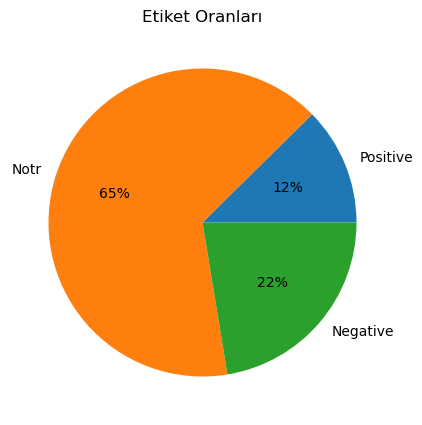

In [43]:
positive = test_df.loc[test_df["label"] == 1].count()[0]
notr = test_df.loc[test_df["label"] == 0].count()[0]
negative = test_df.loc[test_df["label"] == -1].count()[0]

labels_r = ["Positive","Notr","Negative"]

plt.figure(figsize=(8,5),dpi = 100)
plt.pie([positive,notr,negative],labels = labels_r,autopct="%.f%%")
plt.title("Etiket Oranları")
plt.show()

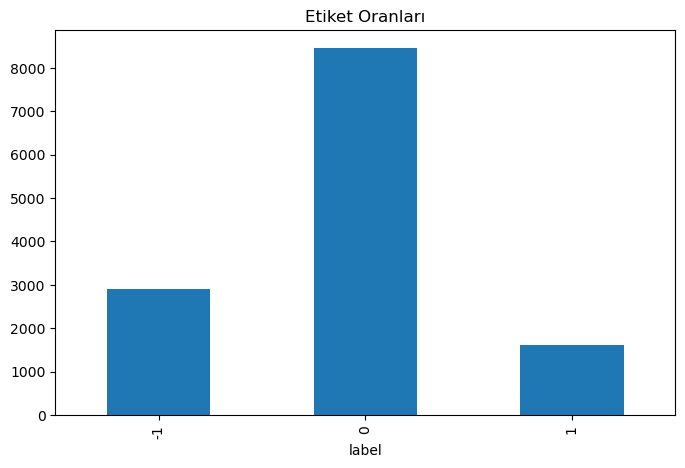

In [47]:
ax = test_df["label"].value_counts().sort_index().plot(kind = "bar",title = "Etiket Oranları",figsize = (8,5))
plt.show()

##### 2. How does the distribution of labels vary over time (date)?

In [63]:
columns1 = ["seasons","label"]
label_by_seasons = test_df[columns1].groupby(["seasons","label"])
a = label_by_seasons.value_counts()
a.head()

seasons   label   
Kış       Positive    4258
Sonbahar  Positive    3461
Yaz       Positive    2848
İlkbahar  Positive    2392
Name: count, dtype: int64

NameError: name 'counts' is not defined

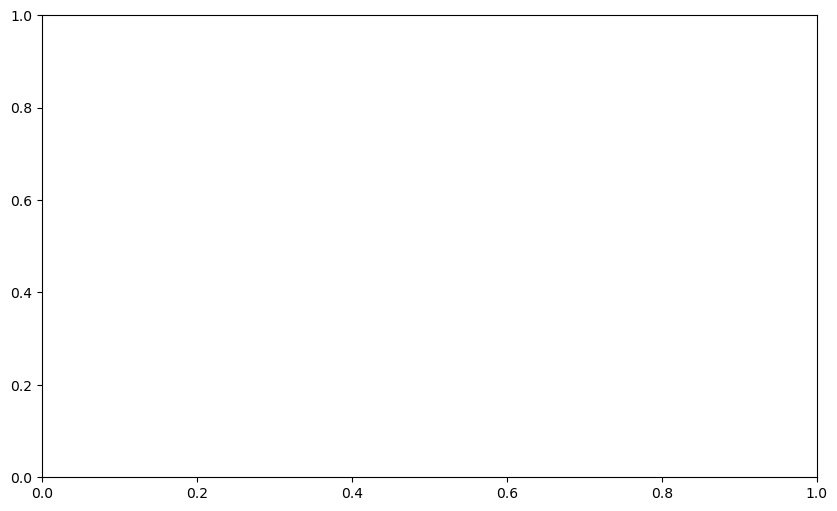

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))

# Width of a single bar
bar_width = 0.2

x = range(len(label_by_seasons["seasons"]))

for i, test_df["label"] in enumerate(labels):
    ax.bar([pos + i * bar_width for pos in x], counts[i], width=bar_width, label=label)

# Set x-axis labels
ax.set_xticks([pos + bar_width for pos in x])
ax.set_xticklabels(label_by_seasons["seasons"])

# Add legend
ax.legend(title='Label')

# Add labels and title
ax.set_xlabel('Seasons')
ax.set_ylabel('Counts')
ax.set_title('Counts of Labels by Seasons')

# Show plot
plt.grid(True)
plt.show()

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (12, 2) + inhomogeneous part.

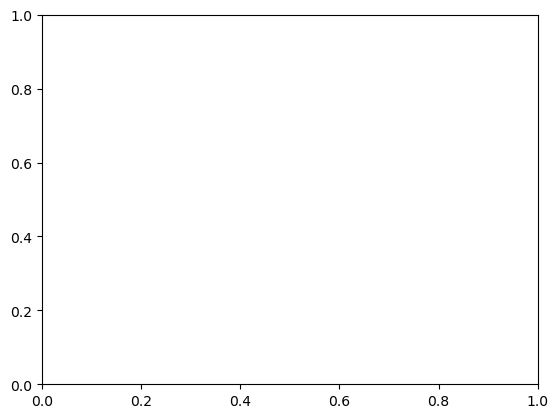

In [40]:
columns1 = ["seasons","label"]
label_by_seasons = test_df[columns1].groupby(["seasons","label"])

labels_s = ["İlkbahar","Yaz","Sonbahar","Kış"]
plt.bar(label_by_seasons["seasons"],label_by_seasons["label"])
plt.show()

## Model Training

## Deployment

In [ ]:
pip install streamlit

In [ ]:
def cleaning_text(text):
    text = text.lower()
    text = classification(text,emoticon_dict)
    text = re.sub(r'[^a-zA-Z0-9]', ' ', text)
    
    word_and_space_remover = lambda x: "".join([w for w in x.split() if len(w)>1])
    text = word_and_space_remover(text)